In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 790ms/step - loss: 0.1475
Average validation loss: 0.5112236142158508
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - loss: 0.1475 - val_loss: 0.5112
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 836ms/step - loss: 0.1169 - val_loss: 0.5112
Average validation loss: 0.43218085169792175
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 858ms/step - loss: 0.1169 - val_loss: 0.4717
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 843ms/step - loss: 0.0920 - val_loss: 0.4717
Average validation loss: 0.35314303636550903
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 856ms/step - loss: 0.0920 - val_loss: 0.4322
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 855ms/step - loss: 0.0163
Average validation loss: 0.16135712713003159
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 869ms/step - loss: 0.0163 - val_loss: 0.1614
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 809ms/step - loss: 0.0153 - val_loss: 0.1614
Average validation loss: 0.23834159970283508
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 825ms/step - loss: 0.0153 - val_loss: 0.1998
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 988ms/step - loss: 0.0144 - val_loss: 0.1998
Average validation loss: 0.30183134227991104
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 999ms/step - loss: 0.0144 - val_loss: 0.2338
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 821ms/step - loss: 0.0137 - val_loss: 0.2338
Average validation loss: 0.46424469351768494
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 833ms/step - loss: 0.0137 - val_loss: 0.2914
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 801ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 975ms/step - loss: 0.0089
Average validation loss: 0.5522687236467997
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 987ms/step - loss: 0.0089 - val_loss: 0.5523
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 829ms/step - loss: 0.0076 - val_loss: 0.5523
Average validation loss: 0.03948211328436931
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 844ms/step - loss: 0.0076 - val_loss: 0.2959
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 800ms/step - loss: 0.0065 - val_loss: 0.2959
Average validation loss: 0.04951865319162607
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 814ms/step - loss: 0.0065 - val_loss: 0.2138
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 819ms/step - loss: 0.0058 - val_loss: 0.2138
Averag

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - loss: 0.0029
Average validation loss: 0.048584844218567014
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 833ms/step - loss: 0.0029 - val_loss: 0.0486
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 831ms/step - loss: 0.0026 - val_loss: 0.0486
Average validation loss: 0.04491577664157376
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 844ms/step - loss: 0.0026 - val_loss: 0.0468
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 825ms/step - loss: 0.0023 - val_loss: 0.0468
Average validation loss: 0.09577006264589727
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 839ms/step - loss: 0.0023 - val_loss: 0.0631
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 834ms/step - loss: 0.0021 - val_loss: 0.0631
Aver

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 814ms/step - loss: 0.0053
Average validation loss: 0.011465067835524678
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 826ms/step - loss: 0.0053 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 789ms/step - loss: 0.0043 - val_loss: 0.0115
Average validation loss: 0.01183655676431954
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 802ms/step - loss: 0.0043 - val_loss: 0.0117
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 793ms/step - loss: 0.0036 - val_loss: 0.0117
Average validation loss: 0.007665911689400673
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 805ms/step - loss: 0.0036 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 789ms/step - loss: 0.0035 - val_loss: 0.0103
Ave

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 966ms/step - loss: 0.0056
Average validation loss: 0.013089848294233283
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 979ms/step - loss: 0.0056 - val_loss: 0.0131
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 857ms/step - loss: 0.0042 - val_loss: 0.0131
Average validation loss: 0.005802279881512125
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 869ms/step - loss: 0.0042 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 797ms/step - loss: 0.0037 - val_loss: 0.0094
Average validation loss: 0.003113636475366851
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 808ms/step - loss: 0.0037 - val_loss: 0.0073
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 790ms/step - loss: 0.0057
Average validation loss: 0.04185881672310643
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - loss: 0.0057 - val_loss: 0.0419
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 838ms/step - loss: 0.0042 - val_loss: 0.0419
Average validation loss: 0.1325945656746626
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 853ms/step - loss: 0.0042 - val_loss: 0.0872
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 829ms/step - loss: 0.0035 - val_loss: 0.0872
Average validation loss: 0.05037467312067747
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 843ms/step - loss: 0.0035 - val_loss: 0.0749
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 801ms/step - loss: 0.0031 - val_loss: 0.0749
Average validation loss: 0.04301194771542214
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 814ms/step - loss: 0.0031 - val_loss: 0.0670
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 885ms/step - loss: 0.0033
Average validation loss: 0.007415064416515331
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 899ms/step - loss: 0.0033 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 835ms/step - loss: 0.0026 - val_loss: 0.0074
Average validation loss: 0.004652420490553292
48/48 ━━━━━━━━━━━━━━━━━━━━ 84s 849ms/step - loss: 0.0026 - val_loss: 0.0060
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 824ms/step - loss: 0.0022 - val_loss: 0.0060
Average validation loss: 0.004737645319740598
48/48 ━━━━━━━━━━━━━━━━━━━━ 124s 837ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 163s 817ms/step - loss: 0.0021 - val_loss: 0.0056

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 829ms/step - loss: 0.0021
Average validation loss: 0.011650666062320982
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 842ms/step - loss: 0.0021 - val_loss: 0.0117
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 801ms/step - loss: 0.0019 - val_loss: 0.0117
Average validation loss: 0.0047856237340186325
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 815ms/step - loss: 0.0019 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 813ms/step - loss: 0.0016 - val_loss: 0.0082
Average validation loss: 0.004303381179592439
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 826ms/step - loss: 0.0016 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 796ms/step - loss: 0.0019
Average validation loss: 0.004507453690166585
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 809ms/step - loss: 0.0019 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 901ms/step - loss: 0.0016 - val_loss: 0.0045
Average validation loss: 0.008659879975311924
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 914ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 166s 862ms/step - loss: 0.0013 - val_loss: 0.0066
Average validation loss: 0.02678367920452729
64/64 ━━━━━━━━━━━━━━━━━━━━ 166s 875ms/step - loss: 0.0013 - val_loss: 0.0133
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 218s 802ms/step - loss: 0.0012 - val_loss: 0.0133
Average validation loss: 0.008217022412281949
64/64 ━━━━━━━━━━━━━━━━━━━━ 218s 814ms/step - loss: 0.0012 - val_loss: 0.0120
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 819ms/step - loss: 0.0016
Average validation loss: 0.016423454691701207
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 832ms/step - loss: 0.0016 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 820ms/step - loss: 0.0014 - val_loss: 0.0164
Average validation loss: 0.01631723192824413
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 833ms/step - loss: 0.0014 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 842ms/step - loss: 0.0012 - val_loss: 0.0164
Average validation loss: 0.016813629947137088
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 854ms/step - loss: 0.0012 - val_loss: 0.0165
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 242s 844ms/step - loss: 0.0011 - val_loss: 0.016

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 810ms/step - loss: 0.0013
Average validation loss: 0.033091044542379676
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 822ms/step - loss: 0.0013 - val_loss: 0.0331
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 795ms/step - loss: 0.0012 - val_loss: 0.0331
Average validation loss: 0.014703538114554248
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 808ms/step - loss: 0.0012 - val_loss: 0.0239
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 799ms/step - loss: 0.0011 - val_loss: 0.0239
Average validation loss: 0.004337198537541553
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 812ms/step - loss: 0.0011 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 797ms/step - loss: 0.0017
Average validation loss: 0.010286103837036839
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 810ms/step - loss: 0.0017 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 796ms/step - loss: 0.0014 - val_loss: 0.0103
Average validation loss: 0.011165150225375934
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 809ms/step - loss: 0.0014 - val_loss: 0.0107
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 795ms/step - loss: 0.0012 - val_loss: 0.0107
Average validation loss: 0.011362982717400882
96/96 ━━━━━━━━━━━━━━━━━━━━ 233s 807ms/step - loss: 0.0012 - val_loss: 0.0109
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 310s 802ms/step - loss: 0.0011 - val_loss: 0.0109
Average validation loss: 0.02095729247230338
96/96 ━━━━━━━━━━━━━━━━━━━━ 311s 815ms/step - loss: 0.0011 - val_loss: 0.0134
Epoch 5/10
96/96 ━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 795ms/step - loss: 0.0026
Average validation loss: 0.008324765152065084
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 808ms/step - loss: 0.0026 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 799ms/step - loss: 0.0020 - val_loss: 0.0083
Average validation loss: 0.03189555281617989
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 812ms/step - loss: 0.0020 - val_loss: 0.0201
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 807ms/step - loss: 0.0018 - val_loss: 0.0201
Average validation loss: 0.01756100885492439
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 820ms/step - loss: 0.0018 - val_loss: 0.0193
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 798ms/step - loss: 0.0016 - val_loss: 0.0193
Average validation loss: 0.016689580083281422
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 811ms/step - loss: 0.0016 - val_loss: 0.0186
Epoch 5/10
120/1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 802ms/step - loss: 0.0023
Average validation loss: 0.005145281802267871
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 815ms/step - loss: 0.0023 - val_loss: 0.0051
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 797ms/step - loss: 0.0019 - val_loss: 0.0051
Average validation loss: 0.004481126831605151
144/144 ━━━━━━━━━━━━━━━━━━━━ 234s 809ms/step - loss: 0.0019 - val_loss: 0.0048
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 802ms/step - loss: 0.0017 - val_loss: 0.0048
Average validation loss: 0.00746175053306312
144/144 ━━━━━━━━━━━━━━━━━━━━ 351s 814ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 468s 812ms/step - loss: 0.0015

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 794ms/step - loss: 0.0015
Average validation loss: 0.01569395164551679
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 807ms/step - loss: 0.0015 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 795ms/step - loss: 0.0012 - val_loss: 0.0157
Average validation loss: 0.004324323828041088
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 808ms/step - loss: 0.0012 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 385s 794ms/step - loss: 0.0011 - val_loss: 0.0100
Average validation loss: 0.005977560486644507
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 807ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 516s 806ms/step - loss: 0.0010

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 795ms/step - loss: 0.0016
Average validation loss: 0.008993113080505282
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 807ms/step - loss: 0.0016 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 839ms/step - loss: 0.0014 - val_loss: 0.0090
Average validation loss: 0.007669912401518708
200/200 ━━━━━━━━━━━━━━━━━━━━ 332s 852ms/step - loss: 0.0014 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 493s 807ms/step - loss: 0.0012 - val_loss: 0.0083
Average validation loss: 0.007107576993396449
200/200 ━━━━━━━━━━━━━━━━━━━━ 496s 820ms/step - loss: 0.0012 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weig

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 811ms/step - loss: 0.0012
Average validation loss: 0.0038108134882349986
240/240 ━━━━━━━━━━━━━━━━━━━━ 198s 824ms/step - loss: 0.0012 - val_loss: 0.0038
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 394s 816ms/step - loss: 0.0010 - val_loss: 0.0038
Average validation loss: 0.00402343580088124
240/240 ━━━━━━━━━━━━━━━━━━━━ 397s 829ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 796ms/step - loss: 9.1740e-04 - val_loss: 0.0039
Average validation loss: 0.004381184126947613
240/240 ━━━━━━━━━━━━━━━━━━━━ 591s 809ms/step - loss: 9.1740e-04 - val_loss: 0.0041
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 782s 796ms/step - loss: 8.7881e-04 - val_loss: 0.0041
Average validation loss: 0.007375746317356213
240/240 ━━━━━━━━━━━━━━━━━━━━ 786s 809ms/step - loss: 8.7881e-04 - val_loss: 0.0

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1678493170067668, 0.14995347946882248, 0.05905184043648964, 0.05066482753842138, 0.025140688320505433, 0.03217947810524493, 0.05440460838668514, 0.016298386721488596, 0.020173885993780068, 0.007599387636510073, 0.01088095139906121, 0.01649096646682301, 0.012692560963611566, 0.012502846640786934, 0.00684054359769786, 0.005204943101578303, 0.009280893758104062, 0.005432482621370059]
std_val_losses =  [0.1145002244140504, 0.14481968837683198, 0.09294193183295327, 0.06697031050069623, 0.05171183819265895, 0.06538413531094324, 0.10462778762103331, 0.042553213756013585, 0.067908359078261, 0.00924740228354051, 0.024988769910273753, 0.03154011654765176, 0.026699350009814805, 0.02532396572044934, 0.008399761686597654, 0.004344461209255439, 0.022901675399192623, 0.008567167366587218]


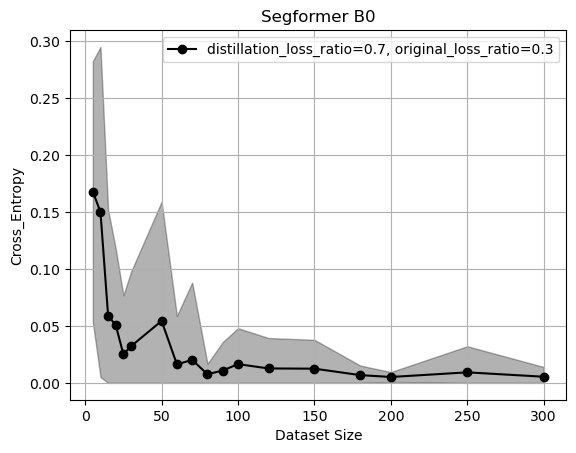

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()